In [2]:
import pandas as pd
import numpy as np

import re
from sklearn.pipeline import Pipeline


from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import string

import logging
from textblob import TextBlob



import warnings
warnings.filterwarnings("ignore")

In [3]:
train_df_news = pd.read_csv("news_classification_train_set.csv", index_col=0)

In [4]:
test_df_news = pd.read_csv("news_classification_test_set_empty.csv", index_col=0)

In [5]:
df_news = pd.concat([train_df_news, test_df_news])

In [6]:
df_news.shape

(200853, 3)

In [7]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200853 entries, 0 to 50212
Data columns (total 3 columns):
headline             200847 non-null object
short_description    181141 non-null object
category             150640 non-null object
dtypes: object(3)
memory usage: 6.1+ MB


In [8]:
df_news['category'].value_counts().plot( kind='bar', figsize=(15,10))

In [9]:
#similar category merge like ARTS & CULTURE'or 'CULTURE & ARTS or ARTS represent the same category,...
#No need of them to be 3 seperated categories

df_news['category'].replace({'TECH':'SCIENCE & TECH',
                                 'SCIENCE':'SCIENCE & TECH',
                                 'THE WORLDPOST':'WORLD NEWS',
                                 'WORLDPOST':'WORLD NEWS',
                                 'PARENTS':'PARENTING',
                                 'STYLE':'STYLE & BEAUTY',
                                 'ARTS & CULTURE':'CULTURE & ARTS',
                                 'ARTS':'CULTURE & ARTS',
                                 'COLLEGE':'EDUCATION', 
                                 'HEALTHY LIVING':'WELLNESS',
                                 'BLACK VOICES':'MINORITY VOICES',
                                 'LATINO VOICES':'MINORITY VOICES',
                                 'QUEER VOICES':'MINORITY VOICES',
                                 'GREEN':'ENVIRONMENT',
                                 'TASTE':'FOOD & DRINK',
                                 'BUSINESS':'ECONOMY',
                                 'MONEY':'ECONOMY'}, inplace=True)

In [10]:
df_news['category'].nunique()

27

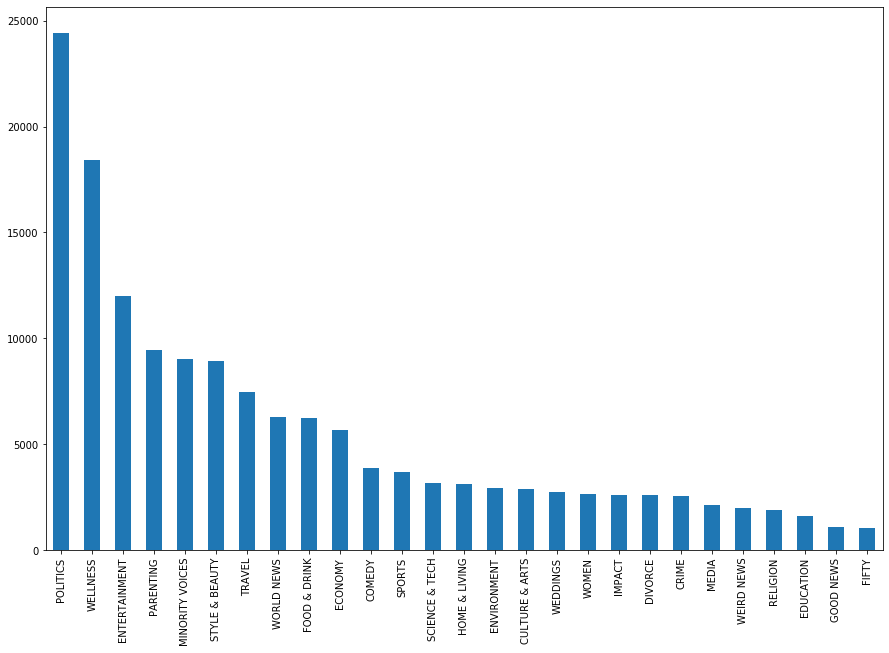

In [11]:
df_news['category'].value_counts().plot( kind='bar', figsize=(15,10))

In [12]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200853 entries, 0 to 50212
Data columns (total 3 columns):
headline             200847 non-null object
short_description    181141 non-null object
category             150640 non-null object
dtypes: object(3)
memory usage: 6.1+ MB


In [13]:
df_news.fillna(" ", inplace=True)


In [14]:
df_news['text'] = df_news['headline'] + " " + df_news['short_description']

In [15]:
#Function to clean, tokenize, remove stop word, and not alphanumeric from data¶

stop_words_ = set(stopwords.words('english'))
wn = WordNetLemmatizer()


def black_txt(token):
    return  token not in stop_words_ and token not in list(string.punctuation)  and len(token)>2 
  
def clean_txt(text):
    clean_text = []
    clean_text2 = []
    text = re.sub("'", "",text)
    text=re.sub("(\\d|\\W)+"," ",text)    
    clean_text = [ wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)]
    clean_text2 = [word for word in clean_text if black_txt(word)]
    return " ".join(clean_text2)

In [16]:
def polarity_txt(text):
    return TextBlob(text).sentiment[0]

In [17]:
def subj_txt(text):
    return  TextBlob(text).sentiment[1]

In [18]:
def len_text(text):
    if len(text.split())>0:
         return len(set(clean_txt(text).split()))/ len(text.split())
    else:
         return 0

In [19]:
df_news['polarity'] = df_news['text'].apply(polarity_txt)
df_news.head(2)

,headline,short_description,category,text,polarity
0,Jared Kushner Arrives In Israel For Whirlwind ...,It remains unclear what approach the White Hou...,POLITICS,Jared Kushner Arrives In Israel For Whirlwind ...,0.0
1,'The Best Thing Is To See How Much Love Can Do...,,MINORITY VOICES,'The Best Thing Is To See How Much Love Can Do...,0.5


In [20]:
df_news['subjectivity'] = df_news['text'].apply(subj_txt)
df_news.head(2)

,headline,short_description,category,text,polarity,subjectivity
0,Jared Kushner Arrives In Israel For Whirlwind ...,It remains unclear what approach the White Hou...,POLITICS,Jared Kushner Arrives In Israel For Whirlwind ...,0.0,0.000000
1,'The Best Thing Is To See How Much Love Can Do...,,MINORITY VOICES,'The Best Thing Is To See How Much Love Can Do...,0.5,0.333333


In [21]:
df_news['len'] = df_news['text'].apply(len_text)
df_news.head(2)

,headline,short_description,category,text,polarity,subjectivity,len
0,Jared Kushner Arrives In Israel For Whirlwind ...,It remains unclear what approach the White Hou...,POLITICS,Jared Kushner Arrives In Israel For Whirlwind ...,0.0,0.000000,0.6
1,'The Best Thing Is To See How Much Love Can Do...,,MINORITY VOICES,'The Best Thing Is To See How Much Love Can Do...,0.5,0.333333,0.4


In [22]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction import DictVectorizer
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]


class TextStats(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, data):
        return [{'pos':  row['polarity'], 'sub': row['subjectivity'],  'len': row['len']} for _, row in data.iterrows()]

In [23]:
pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the text
            ('text', Pipeline([
                ('selector', ItemSelector(key='text')),
                ('tfidf', TfidfVectorizer( min_df =3, max_df=0.2, max_features=None, 
                    strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                    ngram_range=(1, 10), use_idf=1,smooth_idf=1,sublinear_tf=1,
                    stop_words = None, preprocessor=clean_txt)),
            ])),

            # Pipeline for pulling metadata features
            ('stats', Pipeline([
                ('selector', ItemSelector(key=['polarity', 'subjectivity', 'len'])),
                ('stats', TextStats()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'text': 0.9,
            'stats': 1.5,
        },
    ))
])

# Build the Pipeline

In [24]:
df_news.head()

,headline,short_description,category,text,polarity,subjectivity,len
0,Jared Kushner Arrives In Israel For Whirlwind ...,It remains unclear what approach the White Hou...,POLITICS,Jared Kushner Arrives In Israel For Whirlwind ...,0.00,0.000000,0.600000
1,'The Best Thing Is To See How Much Love Can Do...,,MINORITY VOICES,'The Best Thing Is To See How Much Love Can Do...,0.50,0.333333,0.400000
2,Berlin's Nightlife: 48 Hours You Might Not Rem...,If you think spending time boozing and schmooz...,TRAVEL,Berlin's Nightlife: 48 Hours You Might Not Rem...,0.00,0.000000,0.515152
3,Finding Strength to Stand on Your Own,I was so used to being taken care of by family...,DIVORCE,Finding Strength to Stand on Your Own I was so...,0.35,0.650000,0.428571
4,Alexander Wang Lawsuit Will Move To Federal Co...,Representatives of Alexander Wang's brand cont...,STYLE & BEAUTY,Alexander Wang Lawsuit Will Move To Federal Co...,0.00,0.000000,0.678571


In [25]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
seed = 40
X_total = df_news
X_train_df = df_news[df_news['category']!= " "]
X_test_df = df_news[df_news['category'] == " "]

X = X_train_df[['text', 'polarity', 'subjectivity', 'len']]
y = X_train_df['category']
X_test = X_test_df[['text', 'polarity', 'subjectivity', 'len']]

encoder = LabelEncoder()
y = encoder.fit_transform(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)


In [26]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

In [27]:
pipeline.fit(X_total)

Pipeline(memory=None,
         steps=[('union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('text',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  ItemSelector(key='text')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.float64'>,
                                                                                  encoding='utf-8',
                      

# ML models

In [28]:
train_vec = pipeline.transform(x_train)
test_vec = pipeline.transform(x_test)
final_test_vec = pipeline.transform(X_test)

In [29]:
clf_sv = LinearSVC(C=1, class_weight='balanced', multi_class='ovr', random_state=40, max_iter=10000) 
clf_sgd = SGDClassifier(max_iter=200,) 



In [30]:
from sklearn.model_selection import cross_val_score

clfs = [clf_sv, clf_sgd]
cv = 3
for clf in clfs:
    scores = cross_val_score(clf,train_vec, y_train, cv=cv, scoring="accuracy" )
    print (scores)
    print (("Mean score: {0:.3f} (+/-{1:.3f})").format(
        np.mean(scores), np.std(scores)))

[0.66865761 0.67103986 0.67493339]
Mean score: 0.672 (+/-0.003)
[0.62318949 0.62199706 0.63369936]
Mean score: 0.626 (+/-0.005)


In [31]:
from sklearn.metrics import classification_report
clf_sv.fit(train_vec, y_train )
y_pred = clf_sv.predict(test_vec)
list_result =[]
list_result.append(("SVC accuracy is",accuracy_score(y_test, y_pred)))
print(list_result)

[('SVC accuracy is', 0.6784718534253851)]


In [32]:
answer = clf_sv.predict(final_test_vec)

In [33]:
category_name = encoder.inverse_transform(answer)

In [34]:
category_name

array([ 6,  6,  0, ...,  2, 19, 19])

In [35]:
test_df_news['category'] = category_name

In [36]:
test_df_news.head(20)

,headline,short_description,category
0,Hugh Grant Marries For The First Time At Age 57,The actor and his longtime girlfriend Anna Ebe...,6
1,Justin Timberlake Visits Texas School Shooting...,"The pop star also wore a ""Santa Fe Strong"" shi...",6
2,Twitter #PutStarWarsInOtherFilms And It Was Un...,"There's no such thing as too much ""Star Wars.""",0
3,Warriors Coach Steve Kerr Calls NFL Ban On Pro...,Forbidding players to take a knee during the n...,19
4,"Jack Johnson Was Pardoned, But Taboo Sex Is St...",A new law to fight sex trafficking targets som...,14
5,Trump's New 'MAGA'-Themed Swimwear Sinks On Tw...,"""Does this swimsuit make me look racist?""",16
6,"Man Faces Charges After Pulling Knife, Stun Gu...","“We thought we were going to die,"" one of the ...",1
7,People Are Rattled By How Much This Nigerian M...,Suleiman Abdulfatai looks like he could be the...,8
8,What You Missed About The Saddest Death In 'Av...,Directors Joe and Anthony Russo answer our mos...,6
9,Harvey Weinstein Accusers Say They Never Thoug...,Some of the actresses who came forward with se...,6


In [37]:
test_df_news.to_csv('/Users/shubh/Downloads/test_news.csv')